# Goal: Find factors and models
[Investopedia Article](https://www.investopedia.com/articles/basics/04/100804.asp#toc-technical-factors)

In [181]:
import yfinance as yf
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import date

## Fundamental Factors


* The level of the earnings base (represented by measures such as EPS, cash flow per share, dividends per share)
* The expected growth in the earnings base
* The discount rate, which is itself a function of inflation
* The perceived risk of the stock


### EPS (earnings per share)
$$\text{Earnings per Share} = \frac{\text{Net Income} − \text{Preferred Dividends}}{\text{End-of-Period Common Shares Outstanding}}$$
  * Earnings per share value is calculated as net income (also known as profits or earnings) divided by available shares
  * To calculate a company's EPS, the balance sheet and income statement are used to find:
    * The period-end number of common shares
    * Dividends paid on preferred stock (if any)
    * The net income or earnings
  * It is more accurate to use a weighted average number of common shares over the reporting term because the number of shares can change over time

In [20]:
EPS_quarterly = yf.Ticker('AMZN').quarterly_financials.T[['Basic EPS', 'Diluted EPS']]
EPS_all = yf.Ticker('AMZN').financials.T[['Basic EPS', 'Diluted EPS']]
EPS_all

,Basic EPS,Diluted EPS
2024-12-31,NaN,NaN
2023-12-31,2.95,2.9
2022-12-31,-0.27,-0.27
2021-12-31,3.298,3.2405
2020-12-31,2.132,2.0915


### Price-to-Earnings (P/E) Ratio

$$\text{P/E Ratio}=\frac{\text{Earnings per share}}{\text{Market value per share}}​$$

* To determine the P/E value, divide the stock price by the EPS
* The price-to-earnings (P/E) ratio measures a company's share price relative to its earnings per share (EPS)
* A company's P/E can also be benchmarked against other stocks in the same industry or against the broader market, such as the S&P 500 Index

In [21]:
forward_pe = yf.Ticker('AMZN').info["forwardPE"] # projected P/E ratio
trailing_pe = yf.Ticker('AMZN').info["trailingPE"] # P/E from the past 12 months

### The earnings base

* Although we are using EPS, an accounting measure, to illustrate the concept of earnings base, there are other measures of earnings power
  * Many argue that cash-flow-based measures are superior
* The way earnings power is measured may also depend on the type of company being analyzed


In [22]:
cash_flow = yf.Ticker('AMZN').cashflow
divs = yf.Ticker('AMZN').dividends

### The Valuation Multiple


1. The expected growth in the earnings base
2. The discount rate, which is used to calculate the present value of the future stream of earnings


## Simple model with just stock price data for Amazon

Based on a few articles I have read, I saw that an LSTM model is a robust way to predict stock prices.

In [62]:
data = yf.Ticker('AMZN') \
  .history(
    start='2020-01-01',
    end=date.today()
  )
prices = data['Close'] \
  .astype(float) \
  .values \
  .reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(prices)

In [75]:
window_size = 12
X = []
y = []
target_dates = data.index[window_size:]

# create 12 month intervals for close prices
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# create train test splits
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# create LSTM model
model = Sequential()
model.add(LSTM(
    units=128,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
)
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# validate model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0341 - val_loss: 0.0043
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0020 - val_loss: 8.5161e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0022 - val_loss: 9.3886e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0019 - val_loss: 8.9092e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0018 - val_loss: 6.1132e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0016 - val_loss: 9.0478e-04
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [76]:
rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

RMSE: 3.88


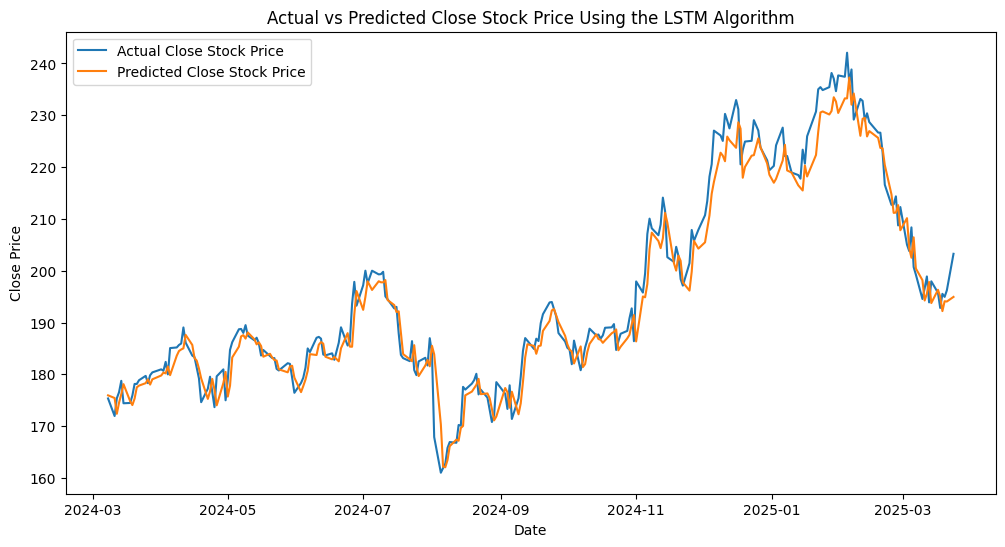

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Close Stock Price')
plt.plot(dates_test, predictions, label='Predicted Close Stock Price')
plt.title('Actual vs Predicted Close Stock Price Using the LSTM Algorithm')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [86]:
# evaluating the model
model.evaluate(X_test, y_test, batch_size=32, verbose=0)

38318.25

This model is a good start, but we should analyze other data to get more information and context. We also should take into account of different time granularities - daily, weekly, monthly, and yearly predictions will have different factors or algorithms that may be more suitable for forecasting.